In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/yap4-heart-diseases-prediction/sample_submission.csv
/kaggle/input/yap4-heart-diseases-prediction/train.csv
/kaggle/input/yap4-heart-diseases-prediction/test.csv


## Подготовка

### Установка LightAutoML

In [2]:
!pip install lightautoml

     |████████████████████████████████| 294 kB 4.0 MB/s            
     |████████████████████████████████| 804.1 MB 1.9 kB/s              
     |████████████████████████████████| 212 kB 56.6 MB/s            
     |████████████████████████████████| 425 kB 70.1 MB/s            
  Preparing metadata (setup.py) ... - \ done
     |████████████████████████████████| 1.2 MB 62.5 MB/s            
     |████████████████████████████████| 3.1 MB 45.0 MB/s            
     |████████████████████████████████| 21.0 MB 48.3 MB/s            
     |████████████████████████████████| 23.2 MB 53.3 MB/s            
     |████████████████████████████████| 23.3 MB 50.9 MB/s            
     |████████████████████████████████| 23.3 MB 53.3 MB/s            
     |████████████████████████████████| 22.1 MB 48.9 MB/s            
     |████████████████████████████████| 22.1 MB 54.4 MB/s            
     |████████████████████████████████| 17.4 MB 58.3 MB/s            
     |████████████████████████████████| 84 kB

### Импорт библиотек

In [3]:
# Стандартные python библиотеки
import os
import time

# Основные библиотеки DS
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import torch

# Предустановки LightAutoML, создание задач и отчетов
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

### Константы

* N_THREADS - кол-во виртуальных ядер для создание модели
* N_FOLDS - кол-во блоков на кросс-валидации
* RANDOM_STATE - параметр псевдослучайности
* TIMEOUT - ограничение в секундах для обучения модели
* TARGET_NAME - целевой признак

In [4]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 1337
TIMEOUT = 2 * 3600
TARGET_NAME = 'cardio'
INPUT_DIR = '../input/yap4-heart-diseases-prediction/'

### Настройки импортированных пакетов

Для лучшей воспроизводимости зафиксируем псевдослучайность в `numpy`, а также максимальное кол-во потоков для Torch

In [5]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

### Загрузка данных. Первый взгляд

Расшифровка столбцов

* id - id пользователей,
* age - возраст,
* gender - пол,
* height - рост,
* weight - вес,
* ap_hi - верхнее артериальное давление,
* ap_lo - нижнее артериальное давление,
* cholesterol - холестерин,
* gluc - глюкоза,
* smoke - курит/не курит,
* alco - выпивает/не выпивает,
* active - ведет активный образ жизни/не ведет,
* cardio - есть проблемы с сердцем/нет проблем

Загрузим данные и просмотрим 5 первых строк

In [6]:
train_data = pd.read_csv(INPUT_DIR + 'train.csv')
print(f'Обучающая выборка: {train_data.shape[0]} строк, {train_data.shape[1]} столбцов')
train_data.head(5)

Обучающая выборка: 70000 строк, 13 столбцов


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [7]:
test_data = pd.read_csv(INPUT_DIR + 'test.csv')
print(f'Тестовая выборка: {test_data.shape[0]} строк, {test_data.shape[1]} столбцов')
test_data.head(5)

Тестовая выборка: 30000 строк, 12 столбцов


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,5,18888,1,154,85.0,130,80,1,1,0,0,1
1,6,19042,2,170,69.0,130,90,1,1,0,0,1
2,7,20432,1,160,70.0,120,75,1,1,0,0,0
3,10,18133,2,185,94.0,130,90,1,1,0,0,1
4,11,16093,2,170,76.0,120,80,1,1,0,0,1


In [8]:
submission = pd.read_csv(INPUT_DIR + 'sample_submission.csv')
print(f'Submission: {submission.shape[0]} строк, {submission.shape[1]} столбцов')
submission.head(5)

Submission: 30000 строк, 2 столбцов


,id,cardio
0,5,0.0
1,6,0.0
2,7,0.0
3,10,0.0
4,11,0.0


Рассмотрим кол-во значений в столбцах, а также типы столбцов

In [9]:
table_nunique_types = pd.concat([train_data.nunique(),
                                   train_data.dtypes],
                                          axis=1).rename(columns={0:'nunique',
                                                                     1:'type'}).sort_values('nunique')
table_nunique_types

,nunique,type
gender,2,int64
smoke,2,int64
alco,2,int64
active,2,int64
cardio,2,int64
cholesterol,3,int64
gluc,3,int64
height,109,int64
ap_hi,153,int64
ap_lo,157,int64


In [10]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,70000.0,49972.419900,28851.302323,0.0,25006.75,50001.5,74889.25,99999.0
age,70000.0,19468.865814,2467.251667,10798.0,17664.00,19703.0,21327.00,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.00,1.0,2.00,2.0
height,70000.0,164.359229,8.210126,55.0,159.00,165.0,170.00,250.0
weight,70000.0,74.205690,14.395757,10.0,65.00,72.0,82.00,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.00,120.0,140.00,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.00,80.0,90.00,11000.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.00,1.0,2.00,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.00,1.0,1.00,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.00,0.0,0.00,1.0


In [11]:
test_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,30000.0,50062.686900,28906.167148,5.0,24983.25,49995.5,75232.25,99997.0
age,30000.0,19455.528400,2477.840922,8865.0,17658.00,19694.0,21320.00,23705.0
gender,30000.0,1.353733,0.478136,1.0,1.00,1.0,2.00,2.0
height,30000.0,164.322267,8.213740,50.0,159.00,165.0,170.00,198.0
weight,30000.0,74.120615,14.341540,10.0,65.00,72.0,82.00,183.0
ap_hi,30000.0,130.271300,212.501152,-130.0,120.00,120.0,140.00,16020.0
ap_lo,30000.0,95.689000,163.852598,-90.0,80.00,80.0,90.00,9100.0
cholesterol,30000.0,1.368033,0.679166,1.0,1.00,1.0,2.00,3.0
gluc,30000.0,1.222700,0.566494,1.0,1.00,1.0,1.00,3.0
smoke,30000.0,0.088600,0.284170,0.0,0.00,0.0,0.00,1.0


Есть отрицательные значения в *ap_hi* и *ap_lo*, изменим на положительные

In [12]:
train_data[['ap_hi', 'ap_lo']] = train_data[['ap_hi', 'ap_lo']].abs()
test_data[['ap_hi', 'ap_lo']] = test_data[['ap_hi', 'ap_lo']].abs()

#### EDA

Здесь должно быть EDA

#### Продожение обработки данных

Напишем функцию, которая возвращает начало и конец диапазона $Q1-n*IQR$ и $Q3+n*IQR$

In [13]:
def interval_iqr(data, col, n_iqr_lo, n_iqr_hi):
    """
    функция принимает на вход DataFrame
    и название столбца,
    возвращает tuple(начало промежутка q1-n_iqr_lo*iqr
    и конец промежутка q3+n_iqr_hi*iqr)
    """
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    start = q1 - n_iqr_lo * iqr
    finish = q3 + n_iqr_hi * iqr
    
    return (start, finish)

Создадим полный датасет со всеми наблюдениями, по которым будем определять выбросы

In [14]:
full_data = pd.concat([train_data.loc[:, train_data.columns != 'cardio'], test_data])
full_data

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
0,0,18393,2,168,62.0,110,80,1,1,0,0,1
1,1,20228,1,156,85.0,140,90,3,1,0,0,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0
3,3,17623,2,169,82.0,150,100,1,1,0,0,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
29995,99984,21722,2,170,103.0,150,90,1,1,0,1,0
29996,99987,18309,1,172,78.0,110,70,1,1,0,0,1
29997,99989,21247,2,169,61.0,120,80,1,1,0,0,0
29998,99994,14509,2,175,80.0,120,80,2,1,0,0,0


### Обработка train_data

Были выявлены дубликаты, где ошибочно внесены *ap_hi* и *ap_lo* в *height* и *weight*

In [15]:
pd.set_option('display.max_rows', 222)
train_data.query('height == ap_hi & weight == ap_lo')

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
1143,1586,23351,1,150,90.0,150,90,3,2,0,0,1,1
1503,2122,16534,1,164,73.0,164,73,1,1,0,0,1,1
3420,4838,14516,1,100,70.0,100,70,1,1,0,0,1,0
3735,5278,17642,1,120,70.0,120,70,1,1,0,0,1,0
3799,5378,23434,1,150,61.0,150,61,1,3,0,0,1,1
4212,5946,16110,1,120,80.0,120,80,1,1,0,0,1,0
7058,10053,21025,1,140,90.0,140,90,3,1,0,0,1,1
7305,10412,15859,1,120,80.0,120,80,1,1,0,0,1,0
8871,12651,18829,2,160,90.0,160,90,2,2,0,0,1,1
9284,13227,14618,2,120,80.0,120,80,1,1,0,0,1,0


Перезапишем train_data без этих значений

In [16]:
train_data = train_data.query('not(height == ap_hi & weight == ap_lo)').copy()

#### *ap_hi*

Для количественных переменных скорректируем выбросы. Просмотрим значения в *ap_hi*

In [17]:
temp_interval = interval_iqr(full_data, 'ap_hi', 3, 5)
print(temp_interval)
train_data.loc[(train_data['ap_hi'] > int(temp_interval[1])) | (train_data['ap_hi'] < int(temp_interval[0]))]

(60.0, 240.0)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
567,815,21281,1,168,78.0,14,90,2,1,0,0,1,1
927,1294,21867,2,175,70.0,14,90,3,1,0,0,1,1
979,1360,18225,1,172,65.0,11,80,1,3,0,0,1,0
1600,2260,19201,1,165,66.0,12,80,1,1,0,0,1,0
1627,2301,22591,1,165,71.0,14,80,1,1,0,0,1,1
1772,2505,14365,2,168,64.0,11,60,1,1,1,1,1,0
1876,2654,15116,1,160,60.0,902,60,1,1,0,0,1,0
2014,2845,22712,2,167,59.0,906,0,1,1,0,0,1,0
2167,3057,21945,2,169,75.0,14,80,2,1,0,0,1,1
2203,3112,21776,2,187,80.0,12,80,1,1,1,0,1,0


In [18]:
#Правим вручную значения
train_data.loc[train_data['id'] == 7657, ['ap_hi', 'ap_lo']] = [170, 80]
train_data.loc[train_data['id'] == 12494, ['ap_hi', 'ap_lo']] = [120, 88]
train_data.loc[train_data['id'] == 36325, ['ap_hi', 'ap_lo']] = [120, 80]
train_data.loc[train_data['id'] == 60477, ['ap_hi', 'ap_lo']] = [110, 88]
train_data.loc[train_data['id'] == 75007, ['ap_hi', 'ap_lo']] = [130, 80]
train_data.loc[train_data['id'] == 91933, ['ap_hi', 'ap_lo']] = [135, 85]
train_data.loc[train_data['id'] == 94673, ['ap_hi', 'ap_lo']] = [160, 100]

train_data.loc[train_data['id'] == 2845, ['ap_hi', 'ap_lo']] = [90, 60]
train_data.loc[train_data['id'] == 13616, ['ap_hi', 'ap_lo']] = [110, 70]
train_data.loc[train_data['id'] == 34120, ['ap_hi', 'ap_lo']] = [90, 60]
train_data.loc[train_data['id'] == 45400, ['ap_hi', 'ap_lo']] = [90, 70]
train_data.loc[train_data['id'] == 57646, ['ap_hi', 'ap_lo']] = [130, 90]
train_data.loc[train_data['id'] == 58349, ['ap_hi', 'ap_lo']] = [140, 80]
train_data.loc[train_data['id'] == 59301, ['ap_hi', 'ap_lo']] = [80, 60]
train_data.loc[train_data['id'] == 60565, ['ap_hi', 'ap_lo']] = [90, 60]
train_data.loc[train_data['id'] == 98095, ['ap_hi', 'ap_lo']] = [90, 60]

#Значения ap_hi < 60 нужно домножить на 10
train_data.loc[(train_data['ap_hi'] < 60), 'ap_hi'] = \
train_data.loc[(train_data['ap_hi'] < 60), 'ap_hi'] * 10

#Значения ap_hi > 240 нужно разделить на 10 а затем отфильтровать и еще раз разделить на 10, чтобы избавиться от 5-значных чисел
train_data.loc[(train_data['ap_hi'] > 240), 'ap_hi'] = \
train_data.loc[(train_data['ap_hi'] > 240), 'ap_hi'] // 10

train_data.loc[(train_data['ap_hi'] > 240), 'ap_hi'] = \
train_data.loc[(train_data['ap_hi'] > 240), 'ap_hi'] // 10

#### *ap_lo*

In [19]:
temp_interval = interval_iqr(full_data, 'ap_lo', 3, 5)
print(temp_interval)
train_data.loc[train_data['ap_lo'] > int(temp_interval[1])]

(50.0, 140.0)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
228,314,17489,2,183,98.0,160,1100,1,2,1,0,1,1
241,334,21932,2,157,60.0,160,1000,2,1,0,0,0,1
260,357,18217,1,150,83.0,140,800,1,1,0,0,1,1
329,458,23407,1,176,63.0,160,1000,2,2,0,0,0,1
345,482,18704,1,154,81.0,140,1000,2,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69771,99659,23330,1,167,81.0,160,1000,1,1,0,0,1,1
69872,99798,21808,1,152,56.0,160,1000,1,1,0,0,1,1
69878,99807,21239,2,168,95.0,160,1000,1,1,0,0,1,1
69885,99816,22417,2,166,78.0,170,1000,1,1,0,0,0,0


Так как есть пятизначные значения выбросов *ap_lo*, то также делить на 10 будем 2 раза

In [20]:
train_data.loc[(train_data['ap_lo'] > 200), 'ap_lo'] = \
train_data.loc[(train_data['ap_lo'] > 200), 'ap_lo'] // 10

train_data.loc[(train_data['ap_lo'] > 200), 'ap_lo'] = \
train_data.loc[(train_data['ap_lo'] > 200), 'ap_lo'] // 10

Рассмотрим значения *ap_lo* меньше 50

In [21]:
train_data.loc[(train_data['ap_lo'] < 50)]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
418,594,16658,1,157,72.0,150,30,1,1,0,0,1,1
507,728,16822,1,165,64.0,140,40,1,1,0,0,1,1
5333,7590,20984,1,164,102.0,120,30,2,1,0,0,1,0
6737,9610,16705,1,156,61.0,150,10,1,1,0,0,0,1
7598,10843,14661,2,70,72.0,120,8,1,1,0,0,1,0
8797,12550,21155,1,162,68.0,110,20,1,1,0,0,1,0
9777,13943,21802,1,166,125.0,120,8,3,1,0,0,1,1
10106,14410,18334,1,152,50.0,150,10,3,1,0,0,1,1
10645,15213,20343,1,160,65.0,130,40,3,1,0,0,0,1
11820,16884,18171,1,169,69.0,128,20,1,1,0,0,1,1


Здесь необходимо домножить на 10 значения *ap_lo* меньше 10. Был выбран этот порог, т.к. неизвестно, являются ли значения больше 10 ошибкой.

In [22]:
train_data.loc[(train_data['ap_lo'] < 10), 'ap_lo'] = \
train_data.loc[(train_data['ap_lo'] < 10), 'ap_lo'] * 10

Удалим нулевые значения в *ap_lo*

In [23]:
train_data = train_data.loc[(train_data['ap_lo'] != 0)].copy()

Скорее всего нужна более глубокая обработка этого параметра, т.к. есть значения меньше 40, но точно определить невозможно. Просмотрим также, есть ли значения  *ap_hi* меньше *ap_lo*

In [24]:
train_data.loc[(train_data['ap_hi'] < train_data['ap_lo'])].head(10)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
474,681,19099,1,156,65.0,120,150,2,1,0,0,1,0
636,913,20457,2,169,68.0,70,110,1,1,0,0,1,0
2384,3356,23361,1,154,102.0,90,150,1,1,0,0,0,1
2990,4214,21957,2,182,90.0,80,140,3,3,0,0,1,1
3447,4880,19992,2,180,80.0,80,125,3,3,1,1,1,1
3623,5130,21874,1,160,83.0,80,120,1,1,0,0,1,0
4825,6836,19618,2,164,89.0,90,140,2,2,0,0,1,1
4830,6843,16969,2,159,68.0,70,100,1,1,0,0,0,0
4941,6992,20501,1,160,69.0,80,170,1,1,0,0,1,1
5121,7277,17600,2,173,78.0,90,140,1,1,0,1,1,1


Такие значения есть, скорее всего столбцы просто перепутаны. Исправим это

In [25]:
train_data.loc[(train_data['ap_hi'] < train_data['ap_lo']), ['ap_hi', 'ap_lo']] = \
train_data.loc[(train_data['ap_hi'] < train_data['ap_lo']), ['ap_lo', 'ap_hi']].copy().values

#### ap_diff_hi_lo

Теперь можем создать дополнительный столбец, где рассчитаем разность *ap_hi* и *ap_lo*

In [26]:
train_data['ap_diff_hi_lo'] = (train_data['ap_hi'] - train_data['ap_lo']).copy()
train_data['ap_diff_hi_lo'].describe()

count    69892.000000
mean        45.480684
std         11.842530
min          0.000000
25%         40.000000
50%         40.000000
75%         50.000000
max        220.000000
Name: ap_diff_hi_lo, dtype: float64

Видим, что есть значения, где разность давления равна нулю

In [27]:
train_data.loc[(train_data['ap_diff_hi_lo'] == 0)]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,ap_diff_hi_lo
12785,18238,15787,2,178,105.0,100,100,1,1,0,0,0,1,0
32190,45975,23183,1,162,120.0,100,100,1,1,0,0,1,0,0


удалим такие строчки, их всего 2

In [28]:
train_data = train_data.loc[(train_data['ap_diff_hi_lo'] != 0)].copy()

#### *weight*

Просмотрим также значения столбца *weight*

In [29]:
train_data['weight'].describe()

count    69890.000000
mean        74.197858
std         14.396009
min         10.000000
25%         65.000000
50%         72.000000
75%         82.000000
max        200.000000
Name: weight, dtype: float64

Максимальное значение - 200. Если задан вес в килограммах, то такое значение кажется реальным. Другое дело, что минимальный вес составляет всего 10 килограмм, что больше похоже на ошибку

In [30]:
temp_interval = interval_iqr(full_data, 'weight', 3, 5)
print(temp_interval)
train_data.loc[train_data['weight'] < int(temp_interval[0])]

(14.0, 167.0)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,ap_diff_hi_lo
33817,48318,21582,2,178,11.0,130,90,1,1,0,0,1,1,40
57858,82567,18804,2,165,10.0,180,110,2,2,0,0,1,1,70


Домножим также такие значения на 10

In [31]:
train_data.loc[(train_data['weight'] < 14), 'weight'] = \
train_data.loc[(train_data['weight'] < 14), 'weight'] * 10

Также посмотрим данные, где *weight > height*

In [32]:
print(len(train_data.query('weight > height')))
train_data.query('weight > height')

34


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,ap_diff_hi_lo
389,552,16718,2,165,169.0,120,80,1,1,0,0,1,0,40
435,618,16765,1,186,200.0,130,70,1,1,0,0,0,0,60
2458,3470,23646,2,159,165.0,130,70,1,1,0,0,0,0,60
4743,6716,17218,2,176,180.0,140,90,1,1,0,0,1,1,50
6153,8757,20990,1,122,161.0,120,80,1,1,0,0,1,1,40
7598,10843,14661,2,70,72.0,120,80,1,1,0,0,1,0,40
8171,11662,17646,2,97,170.0,160,100,1,1,1,0,1,1,60
12435,17757,22077,1,137,161.0,150,100,2,1,0,0,0,1,50
12770,18218,19594,1,75,168.0,120,80,1,1,1,0,1,1,40
15366,21958,17405,1,125,167.0,180,90,1,2,0,0,1,1,90


In [33]:
train_data = train_data.query('not(weight > height)').copy()

#### *height*

Просмотрим рост

In [34]:
temp_interval = interval_iqr(full_data, 'height', 3, 5)
print(temp_interval)

(126.0, 225.0)


Возьмем рост меньше 100

In [35]:
train_data.loc[train_data['height'] < 100]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,ap_diff_hi_lo
224,309,21800,2,76,55.0,120,80,1,1,0,0,1,0,40
13265,18928,22456,2,71,68.0,120,80,3,1,0,0,1,0,40
14323,20459,22005,1,67,57.0,120,90,1,1,0,0,1,1,30
15167,21686,15812,1,70,68.0,120,80,1,1,0,0,0,0,40
17277,24690,17530,1,98,45.0,120,80,1,1,0,0,1,0,40
22542,32207,14538,1,68,65.0,100,60,1,1,0,0,0,0,40
27603,39462,20978,1,64,61.0,130,70,1,1,0,0,1,0,60
28737,41075,19747,1,91,55.0,140,90,1,1,0,0,1,1,50
44490,63545,19120,1,65,60.0,120,80,1,1,0,0,1,0,40
47352,67631,23297,1,75,75.0,120,80,1,1,0,0,1,0,40


К таким значениям прибавим 100

In [36]:
train_data.loc[train_data['height'] < 100, 'height'] = \
(train_data.loc[train_data['height'] < 100, 'height'] + 100).copy()

Рост больше 225

In [37]:
train_data.loc[train_data['height'] > 225]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,ap_diff_hi_lo
6486,9223,21220,1,250,86.0,140,100,3,1,0,0,1,1,40


Такое значение всего одно, оставим как есть.

#### Body Mass Index (индекс массы тела)

Помимо стандартного ИМТ можем еще использовать обманчивый ИМТ. Разница в формуле.

*ИМТ = weight / height**2*

Обманчивый *ИМТ = 1.3 * weight / height ** 2.5*

In [38]:
train_data['bmi'] = train_data['weight'] / (train_data['height'] / 100) ** 2
train_data['deceptive_bmi'] = 1.3 * train_data['weight'] / (train_data['height'] / 100) ** 2.5

In [39]:
train_data

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,ap_diff_hi_lo,bmi,deceptive_bmi
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,30,21.967120,22.032402
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,50,34.927679,36.353881
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,60,23.507805,23.791042
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,50,28.710479,28.710479
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,40,23.011177,23.950792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0,40,26.927438,27.007460
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1,50,50.472681,52.200081
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1,90,31.353579,30.130402
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1,55,27.099251,27.593503


### Обработка test_data

Просмотрим строки, где рост и вес совпадают с верхним и нижним давлением

In [40]:
test_data.query('height == ap_hi and weight == ap_lo')

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
187,629,19808,1,160,100.0,160,100,1,1,0,0,1
195,644,18994,1,110,90.0,110,90,2,2,0,0,1
983,3390,21882,1,130,80.0,130,80,1,1,0,0,1
1917,6522,20494,2,140,90.0,140,90,1,1,0,0,1
2107,7144,17391,2,140,80.0,140,80,1,1,0,0,1
2936,9837,18943,1,165,65.0,165,65,1,1,0,0,1
3089,10347,19681,1,100,70.0,100,70,2,1,0,1,1
3213,10754,19612,1,140,90.0,140,90,1,3,0,0,1
4102,13736,19031,1,160,100.0,160,100,1,1,0,0,1
4152,13896,20278,1,152,67.0,152,67,1,1,0,0,0


Можно заметить, что давление обычно округлено, а рост и вес нет. Сделаем срез, где при делении давления на 10 нет остатка. В таких строках рост и вес изменим на медиану.

In [41]:
test_data.loc[(test_data['height'] == test_data['ap_hi'])
              & (test_data['weight'] == test_data['ap_lo'])
              & (test_data['ap_hi'] % 10 == 0)
              & (test_data['ap_lo'] % 10 == 0), ['height', 'weight']] = \
[int(full_data['height'].median()), full_data['weight'].median()]

Посмотрим оставшиеся значения

In [42]:
test_data.query('height == ap_hi and weight == ap_lo')

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
2936,9837,18943,1,165,65.0,165,65,1,1,0,0,1
4152,13896,20278,1,152,67.0,152,67,1,1,0,0,0
4918,16367,18323,1,163,61.0,163,61,1,1,0,0,1
14243,47445,15285,1,166,83.0,166,83,1,1,0,0,1
14284,47589,18776,2,172,86.0,172,86,1,1,1,0,0
15182,50630,23125,2,176,80.0,176,80,1,1,0,0,1
16857,56207,18954,1,164,68.0,164,68,3,1,0,0,0
18024,60119,20608,2,165,79.0,165,79,2,1,1,1,1
18471,61565,20268,2,153,73.0,153,73,1,1,0,0,1
19983,66699,23404,1,153,75.0,153,75,1,1,0,0,1


В оставшихся значениях заменим давление на медиану

In [43]:
test_data.loc[(test_data['height'] == test_data['ap_hi'])
              & (test_data['weight'] == test_data['ap_lo']),
              ['ap_hi', 'ap_lo']] = \
[int(full_data['ap_hi'].median()), int(full_data['ap_lo'].median())]

#### *ap_hi*
Посмотрим выбросы в тестовой выборке

In [44]:
temp_interval = interval_iqr(full_data, 'ap_hi', 3, 5)
print(temp_interval)
test_data.loc[(test_data['ap_hi'] < int(temp_interval[0])) | (test_data['ap_hi'] > int(temp_interval[1]))]

(60.0, 240.0)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
285,975,15990,2,170,72.0,12,80,2,1,0,0,1
303,1079,22571,2,170,74.0,400,60,1,1,0,0,1
487,1706,20428,2,170,80.0,13,80,1,1,0,0,1
1667,5685,20550,1,159,61.0,10,60,1,1,0,0,1
1685,5736,15180,1,147,53.0,907,70,1,1,0,0,1
1929,6580,19079,1,176,92.0,1,1099,1,1,0,0,1
2003,6817,23201,1,143,44.0,13,80,1,1,0,0,1
2005,6823,18976,1,165,72.0,13,90,2,1,0,0,1
2220,7465,22815,2,160,60.0,11,120,1,3,0,0,0
2443,8272,21060,1,165,72.0,16,10,3,3,0,0,1


Похоже, что в большинстве случаев нужно *ap_hi* домножить на 10. Также есть случаи некорректного ввода, где в ячейку *ap_hi* ввели 1, а в *ap_lo* 2088. Скорее всего имелось ввиду 120 и 88

In [45]:
test_data.loc[test_data['id'] == 6580, ['ap_hi', 'ap_lo']] = [110, 99]
test_data.loc[test_data['id'] == 42755, ['ap_hi', 'ap_lo']] = [130, 90]
test_data.loc[test_data['id'] == 51749, ['ap_hi', 'ap_lo']] = [120, 88]
test_data.loc[test_data['id'] == 97818, ['ap_hi', 'ap_lo']] = [115, 70]

test_data.loc[(test_data['ap_hi'] < int(temp_interval[0])), 'ap_hi'] = \
test_data.loc[(test_data['ap_hi'] < int(temp_interval[0])), 'ap_hi'] * 10

In [46]:
test_data.loc[test_data['id'] == 1079, ['ap_hi', 'ap_lo']] = [100, 60]
test_data.loc[test_data['id'] == 5736, ['ap_hi', 'ap_lo']] = [90, 70]
test_data.loc[test_data['id'] == 17266, ['ap_hi', 'ap_lo']] = [120, 80]
test_data.loc[test_data['id'] == 23199, ['ap_hi', 'ap_lo']] = [95, 70]
test_data.loc[test_data['id'] == 24871, ['ap_hi', 'ap_lo']] = [90, 60]
test_data.loc[test_data['id'] == 25868, ['ap_hi', 'ap_lo']] = [140, 90]
test_data.loc[test_data['id'] == 29568, ['ap_hi', 'ap_lo']] = [160, 70]
test_data.loc[test_data['id'] == 30877, ['ap_hi', 'ap_lo']] = [90, 60]
test_data.loc[test_data['id'] == 31334, ['ap_hi', 'ap_lo']] = [140, 90]
test_data.loc[test_data['id'] == 35256, ['ap_hi', 'ap_lo']] = [150, 80]
test_data.loc[test_data['id'] == 44904, ['ap_hi', 'ap_lo']] = [140, 90]
test_data.loc[test_data['id'] == 45258, ['ap_hi', 'ap_lo']] = [140, 80]
test_data.loc[test_data['id'] == 48185, ['ap_hi', 'ap_lo']] = [140, 90]
test_data.loc[test_data['id'] == 56466, ['ap_hi', 'ap_lo']] = [140, 90]
test_data.loc[test_data['id'] == 61818, ['ap_hi', 'ap_lo']] = [160, 80]
test_data.loc[test_data['id'] == 62837, ['ap_hi', 'ap_lo']] = [150, 90]
test_data.loc[test_data['id'] == 81470, ['ap_hi', 'ap_lo']] = [120, 80]
test_data.loc[test_data['id'] == 88161, ['ap_hi', 'ap_lo']] = [90, 60]
test_data.loc[test_data['id'] == 99929, ['ap_hi', 'ap_lo']] = [90, 60]

In [47]:
len(test_data.loc[(test_data['ap_hi'] < int(temp_interval[0])) | (test_data['ap_hi'] > int(temp_interval[1]))])

0

Значения выбросов *ap_hi* изменены.

#### *ap_lo*

In [48]:
temp_interval = interval_iqr(full_data, 'ap_lo', 3, 5)
print(temp_interval)
test_data.loc[test_data['ap_lo'] > int(temp_interval[1])]

(50.0, 140.0)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
37,151,20891,2,157,66.0,150,1000,3,1,1,1,0
524,1822,18738,1,160,113.0,140,1000,1,1,0,0,0
540,1882,19017,1,161,83.0,140,1000,2,2,0,0,1
601,2076,19704,2,168,68.0,150,1000,2,1,0,0,1
639,2183,20429,1,155,63.0,150,1000,2,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
29720,99093,18815,1,167,83.0,200,1100,1,1,0,0,0
29764,99257,20632,1,168,72.0,180,1000,1,1,0,0,0
29884,99645,23159,1,160,88.0,210,1000,3,3,0,0,1
29946,99850,21089,1,162,74.0,160,1000,1,1,0,0,0


Так как есть пятизначные значения выбросов *ap_lo*, то также делить на 10 будем 2 раза

In [49]:
test_data.loc[(test_data['ap_lo'] > 200), 'ap_lo'] = \
test_data.loc[(test_data['ap_lo'] > 200), 'ap_lo'] // 10

test_data.loc[(test_data['ap_lo'] > 200), 'ap_lo'] = \
test_data.loc[(test_data['ap_lo'] > 200), 'ap_lo'] // 10

Рассмотрим значения *ap_lo* меньше 50

In [50]:
test_data.loc[(test_data['ap_lo'] < 50)]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
1114,3828,14653,2,65,74.0,120,40,2,1,1,0,1
1626,5559,17538,2,167,72.0,120,30,1,1,0,0,1
2371,8018,21291,1,161,88.0,120,30,2,1,0,0,1
2443,8272,21060,1,165,72.0,160,10,3,3,0,0,1
3160,10586,17447,1,160,75.0,170,41,1,1,0,0,1
3515,11745,20874,1,158,79.0,130,40,1,1,0,0,1
6294,20962,20257,1,185,75.0,120,20,1,1,0,0,1
6400,21287,19746,2,168,70.0,160,10,3,3,1,0,1
6870,22925,19076,1,164,60.0,110,7,1,3,0,0,0
7638,25442,15153,2,172,105.0,130,10,2,1,0,0,0


Значения меньше 20 домножим на 10

In [51]:
test_data.loc[(test_data['ap_lo'] < 20), 'ap_lo'] = \
test_data.loc[(test_data['ap_lo'] < 20), 'ap_lo'] * 10

Посмотрим оставшиеся значения

In [52]:
test_data.loc[(test_data['ap_lo'] < 50)]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
1114,3828,14653,2,65,74.0,120,40,2,1,1,0,1
1626,5559,17538,2,167,72.0,120,30,1,1,0,0,1
2371,8018,21291,1,161,88.0,120,30,2,1,0,0,1
3160,10586,17447,1,160,75.0,170,41,1,1,0,0,1
3515,11745,20874,1,158,79.0,130,40,1,1,0,0,1
6294,20962,20257,1,185,75.0,120,20,1,1,0,0,1
7906,26367,20577,1,169,78.0,120,0,2,1,0,0,1
13138,43735,23324,2,184,88.0,100,0,3,1,0,0,0
13629,45450,18125,1,170,86.0,125,47,2,1,0,0,1
15437,51515,20361,1,165,66.0,108,0,1,1,0,0,1


Скорректируем нули

In [53]:
test_data.loc[test_data['id'] == 10586, ['ap_hi', 'ap_lo']] = [170, 140]
test_data.loc[test_data['id'] == 26367, ['ap_hi', 'ap_lo']] = [120, 100]
test_data.loc[test_data['id'] == 43735, ['ap_hi', 'ap_lo']] = [100, 60]
test_data.loc[test_data['id'] == 51515, ['ap_hi', 'ap_lo']] = [100, 80]
test_data.loc[test_data['id'] == 81975, ['ap_hi', 'ap_lo']] = [100, 80]
test_data.loc[test_data['id'] == 97796, ['ap_hi', 'ap_lo']] = [110, 80]

Остальные значения оставим, как есть. Просмотрим также, есть ли значения  *ap_hi* меньше *ap_lo*

In [54]:
test_data.loc[(test_data['ap_hi'] < test_data['ap_lo'])]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
605,2080,21225,2,168,73.0,90,130,1,1,0,0,0
1097,3777,16277,1,169,87.0,90,160,1,1,0,0,1
1112,3825,20009,1,159,71.0,80,130,1,1,0,0,1
1261,4345,21037,1,156,87.0,90,150,3,3,0,0,1
1448,4933,20603,1,150,63.0,90,130,1,1,0,0,0
2009,6832,22464,1,157,87.0,80,120,3,3,0,0,1
2220,7465,22815,2,160,60.0,110,120,1,3,0,0,0
3161,10591,21899,2,172,85.0,100,160,1,1,0,0,0
3238,10815,15447,2,169,74.0,80,120,1,1,0,0,1
3585,11963,21191,2,166,90.0,90,150,2,1,0,0,0


Такие значения есть, скорее всего столбцы просто перепутаны. Исправим это

In [55]:
test_data.loc[(test_data['ap_hi'] < test_data['ap_lo']), ['ap_hi', 'ap_lo']] = \
test_data.loc[(test_data['ap_hi'] < test_data['ap_lo']), ['ap_lo', 'ap_hi']].copy().values

#### ap_diff_hi_lo

Теперь можем создать дополнительный столбец, где рассчитаем разность *ap_hi* и *ap_lo*

In [56]:
test_data['ap_diff_hi_lo'] = (test_data['ap_hi'] - test_data['ap_lo']).copy()

#### *weight*

Просмотрим также значения столбца *weight*

In [57]:
test_data['weight'].describe()

count    30000.000000
mean        74.106415
std         14.332627
min         10.000000
25%         65.000000
50%         72.000000
75%         82.000000
max        183.000000
Name: weight, dtype: float64

Максимальное значение - 183. Если задан вес в килограммах, то такое значение кажется реальным. Другое дело, что минимальный вес составляет всего 10 килограмм, что больше похоже на ошибку

In [58]:
test_data.loc[test_data['weight'] < 30]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,ap_diff_hi_lo
259,854,15187,2,183,13.0,120,80,1,1,0,1,1,40
2317,7812,19785,1,157,10.0,120,80,1,1,0,0,1,40
16349,54609,16018,1,169,16.3,130,80,1,1,0,0,0,50
17418,58027,14848,2,170,20.0,120,80,1,1,0,0,0,40
28825,96186,19026,1,169,10.0,120,80,1,1,0,0,1,40


Предположим, что вес здесь задан с ошибкой (разделен на 10) и в фунтах. Скорректируем

In [59]:
test_data.loc[(test_data['weight'] < 30), 'weight'] = \
(test_data.loc[(test_data['weight'] < 30), 'weight'] * 10 * 0.453592).copy()

#### *height*

Просмотрим рост

In [60]:
test_data['height'].describe()

count    30000.000000
mean       164.352267
std          8.143622
min         50.000000
25%        159.000000
50%        165.000000
75%        170.000000
max        198.000000
Name: height, dtype: float64

Минимальное значение - 50 см, здесь явно какая-то ошибка. Посмотрим строки, где значение веса больше значения роста

In [61]:
test_data.query('weight >= height')

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,ap_diff_hi_lo
730,2495,21771,1,58,183.0,160,100,1,2,0,0,1,60
1114,3828,14653,2,65,74.0,120,40,2,1,1,0,1,80
2431,8207,18384,1,160,168.0,120,80,1,1,0,0,1,40
3170,10620,23353,1,164,168.0,140,80,1,1,0,0,1,60
7879,26298,17511,1,165,180.0,90,60,1,1,0,0,1,30
10595,35345,18920,2,165,169.0,110,70,1,1,0,0,1,40
13261,44218,17612,1,170,171.0,140,90,2,1,0,1,0,50
15109,50367,22671,1,60,155.0,160,100,1,1,0,0,1,60
17850,59517,18270,1,167,167.0,110,70,2,2,0,0,1,40
18312,61030,18899,2,87,173.0,140,80,1,1,0,0,1,60


Поменяем такие значения местами

In [62]:
test_data.loc[(test_data['weight'] > test_data['height']),
             ['weight', 'height']] = \
test_data.loc[(test_data['weight'] > test_data['height']),
             ['height', 'weight']].copy().values

Теперь посмотрим рост меньше 140

In [63]:
full_data['height'].median()

165.0

In [64]:
test_data.loc[(test_data['height'] < 140), 'height'] = \
full_data['height'].median()

#### Body Mass Index (индекс массы тела)

Помимо стандартного ИМТ можем еще использовать обманчивый ИМТ. Разница в формуле.

*ИМТ = weight / height**2*

Обманчивый *ИМТ = 1.3 * weight / height ** 2.5*

In [65]:
test_data['bmi'] = (test_data['weight'] / (test_data['height'] / 100) ** 2).copy()
test_data['deceptive_bmi'] = (1.3 * test_data['weight'] / (test_data['height'] / 100) ** 2.5).copy()

In [66]:
test_data

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,ap_diff_hi_lo,bmi,deceptive_bmi
0,5,18888,1,154.0,85.0,130,80,1,1,0,0,1,50,35.840783,37.545723
1,6,19042,2,170.0,69.0,130,90,1,1,0,0,1,40,23.875433,23.805107
2,7,20432,1,160.0,70.0,120,75,1,1,0,0,0,45,27.343750,28.102272
3,10,18133,2,185.0,94.0,130,90,1,1,0,0,1,40,27.465303,26.250760
4,11,16093,2,170.0,76.0,120,80,1,1,0,0,1,40,26.297578,26.220118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,99984,21722,2,170.0,103.0,150,90,1,1,0,1,0,60,35.640138,35.535160
29996,99987,18309,1,172.0,78.0,110,70,1,1,0,0,1,40,26.365603,26.134659
29997,99989,21247,2,169.0,61.0,120,80,1,1,0,0,0,40,21.357796,21.357796
29998,99994,14509,2,175.0,80.0,120,80,2,1,0,0,0,40,26.122449,25.670730


Посмотрим еще раз статистики

In [67]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,69856.0,49976.026784,28853.897980,0.000000,25005.250000,50009.500000,74893.250000,99999.00000
age,69856.0,19469.102554,2466.870650,10798.000000,17665.000000,19703.000000,21327.000000,23713.00000
gender,69856.0,1.349519,0.476821,1.000000,1.000000,1.000000,2.000000,2.00000
height,69856.0,164.431001,7.921463,100.000000,159.000000,165.000000,170.000000,250.00000
weight,69856.0,74.165645,14.276519,21.000000,65.000000,72.000000,82.000000,180.00000
ap_hi,69856.0,127.039925,17.034637,60.000000,120.000000,120.000000,140.000000,240.00000
ap_lo,69856.0,81.561140,9.819892,10.000000,80.000000,80.000000,90.000000,182.00000
cholesterol,69856.0,1.367026,0.680356,1.000000,1.000000,1.000000,2.000000,3.00000
gluc,69856.0,1.226509,0.572319,1.000000,1.000000,1.000000,1.000000,3.00000
smoke,69856.0,0.088181,0.283561,0.000000,0.000000,0.000000,0.000000,1.00000


In [68]:
test_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,30000.0,50062.686900,28906.167148,5.000000,24983.250000,49995.500000,75232.250000,99997.000000
age,30000.0,19455.528400,2477.840922,8865.000000,17658.000000,19694.000000,21320.000000,23705.000000
gender,30000.0,1.353733,0.478136,1.000000,1.000000,1.000000,2.000000,2.000000
height,30000.0,164.436667,7.783269,140.000000,159.000000,165.000000,170.000000,198.000000
weight,30000.0,74.099016,14.261295,30.000000,65.000000,72.000000,82.000000,173.000000
ap_hi,30000.0,127.079133,16.943787,76.000000,120.000000,120.000000,140.000000,240.000000
ap_lo,30000.0,81.622800,9.711704,20.000000,80.000000,80.000000,90.000000,172.000000
cholesterol,30000.0,1.368033,0.679166,1.000000,1.000000,1.000000,2.000000,3.000000
gluc,30000.0,1.222700,0.566494,1.000000,1.000000,1.000000,1.000000,3.000000
smoke,30000.0,0.088600,0.284170,0.000000,0.000000,0.000000,0.000000,1.000000


## Постановка задачи

### Тип задачи
Создаем объект Task - класс для настройки того, какую задачу должна решать модель LightAutoML с конкретными потерями и метрикой, если это необходимо:

In [69]:
task = Task('binary', loss = 'logloss', metric = 'auc')

### Настройка и определение типов признаков
Чтобы решить эту задачу, нам нужно настроить типы признаков. Единственный тип, который нужно настроить, - это целевой признак, всё остальное зависит от пользователя - модели LightAutoML имеют автоматическую типизацию признаков внутри:

In [70]:
roles = {
    'target': TARGET_NAME,
    'drop': ['id']
}

### LightAutoML создание модели - настройка TabularAutoML
In next the cell we are going to create LightAutoML model with `TabularAutoML` class - preset with default model structure like in the image below:

<img src="https://github.com/sberbank-ai-lab/LightAutoML/raw/master/imgs/tutorial_blackbox_pipeline.png" alt="TabularAutoML preset pipeline" style="width:85%;"/>

in just several lines. Let's discuss the params we can setup:
- `task` - the type of the ML task (the only **must have** parameter)
- `timeout` - time limit in seconds for model to train
- `cpu_limit` - vCPU count for model to use
- `reader_params` - parameter change for Reader object inside preset, which works on the first step of data preparation: automatic feature typization, preliminary almost-constant features, correct CV setup etc. For example, we setup `n_jobs` threads for typization algo, `cv` folds and `random_state` as inside CV seed.

**Important note**: `reader_params` key is one of the YAML config keys, which is used inside `TabularAutoML` preset. [More details](https://github.com/sberbank-ai-lab/LightAutoML/blob/master/lightautoml/automl/presets/tabular_config.yml) on its structure with explanation comments can be found on the link attached. Each key from this config can be modified with user settings during preset object initialization. To get more info about different parameters setting (for example, ML algos which can be used in `general_params->use_algos`) please take a look at our [article on TowardsDataScience](https://towardsdatascience.com/lightautoml-preset-usage-tutorial-2cce7da6f936).

Moreover, to receive the automatic report for our model we will use `ReportDeco` decorator and work with the decorated version in the same way as we do with usual one. 

In [71]:
automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

## AutoML trainig

To run autoML training use fit_predict method:
- `train_data` - Dataset to train.
- `roles` - Roles dict.
- `verbose` - Controls the verbosity: the higher, the more messages.
        <1  : messages are not displayed;
        >=1 : the computation process for layers is displayed;
        >=2 : the information about folds processing is also displayed;
        >=3 : the hyperparameters optimization process is also displayed;
        >=4 : the training process for every algorithm is displayed;

Note: out-of-fold prediction is calculated during training and returned from the fit_predict method

In [72]:
%%time 
oof_pred = automl.fit_predict(train_data, roles = roles, verbose = 3)

[15:09:56] Stdout logging level is INFO3.
[15:09:56] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[15:09:56] Task: binary

[15:09:56] Start automl preset with listed constraints:
[15:09:56] - time: 7200.00 seconds
[15:09:56] - CPU: 4 cores
[15:09:56] - memory: 16 GB

[15:09:56] Train data shape: (69856, 16)

[15:10:00] Feats was rejected during automatic roles guess: []
[15:10:00] Layer 1 train process start. Time left 7195.88 secs
[15:10:00] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[15:10:00] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[15:10:01] Linear model: C = 1e-05 score = 0.7857727848414193
[15:10:01] Linear model: C = 5e-05 score = 0.7915808978282112
[15:10:01] Linear model: C = 0.0001 score = 0.7928723659487381
[15:10:01] Linear model: C = 0.0005 score = 0.7939446723656496
[15:10:01] Linear model: C = 0.001 score = 0.7940558002171414
[15:10:01] Linear model: C = 0.005 score = 0.794149173429872

In [73]:
print(f'OOF score: {roc_auc_score(train_data[TARGET_NAME].values, oof_pred.data[:, 0])}')

OOF score: 0.8044610611320527


## Анализ модели

In [74]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.16620 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
	 0.53586 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.17593 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
	 0.12202 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


CPU times: user 85.6 ms, sys: 59.7 ms, total: 145 ms
Wall time: 107 ms


<AxesSubplot:xlabel='Feature'>

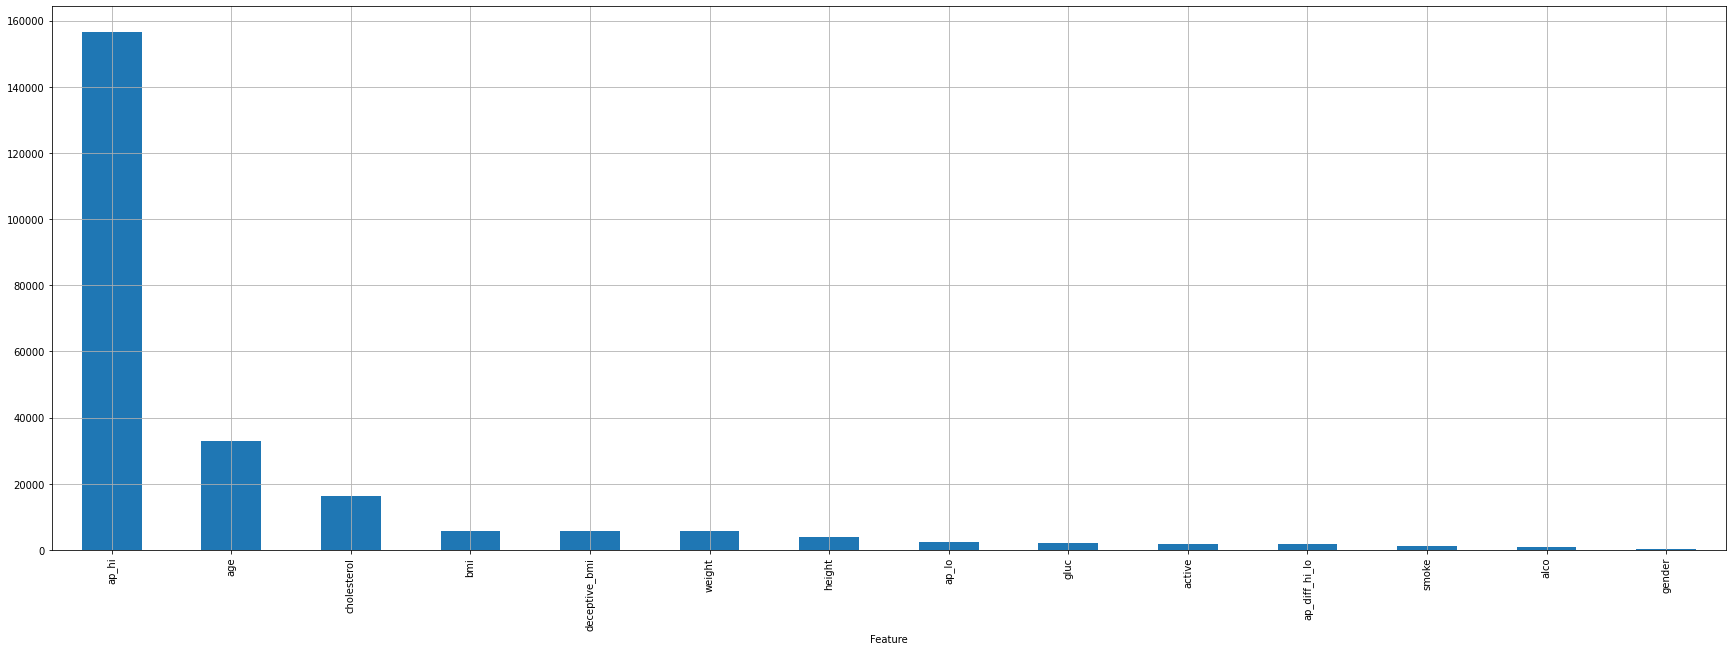

In [75]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.head(30).set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

# 5. Spending more from TIMEOUT - `TabularUtilizedAutoML` usage

Using `TabularAutoML` we spent only 8 minutes to build the model with setup `TIMEOUT` equal to 30 minutes. To spend (almost) all the `TIMEOUT` we can use `TabularUtilizedAutoML` preset instead of `TabularAutoML`, which has the same API:

In [76]:
utilized_automl = TabularUtilizedAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)

In [77]:
%%time 

oof_pred = utilized_automl.fit_predict(train_data, roles = roles, verbose = 1)

[15:21:55] Start automl utilizator with listed constraints:
[15:21:55] - time: 7200.00 seconds
[15:21:55] - CPU: 4 cores
[15:21:55] - memory: 16 GB

[15:21:55] If one preset completes earlier, next preset configuration will be started

[15:21:55] ==================================================
[15:21:55] Start 0 automl preset configuration:
[15:21:55] conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[15:21:55] Stdout logging level is INFO.
[15:21:55] Task: binary

[15:21:55] Start automl preset with listed constraints:
[15:21:55] - time: 7200.00 seconds
[15:21:55] - CPU: 4 cores
[15:21:55] - memory: 16 GB

[15:21:55] Train data shape: (69856, 16)

[15:21:59] Layer 1 train process start. Time left 7196.21 secs
[15:21:59] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[15:22:02] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7931102663828776
[15:22:02] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predi

In [78]:
print('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

oof_pred:
array([[0.15953735],
       [0.83800626],
       [0.7559353 ],
       ...,
       [0.8710832 ],
       [0.72151613],
       [0.41979653]], dtype=float32)
Shape = (69856, 1)


In [79]:
print(utilized_automl.create_model_str_desc())

Final prediction for new objects = 
	0.39104 * 2 averaged models with config = "conf_1_sel_type_1.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.24829 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
			 0.23607 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
			 0.11421 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
			 0.40143 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


	    Model #1.
		Final prediction for new objects (level 0) = 
			 0.15857 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
			 0.31791 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
			 0.46019 * (5 averaged models Lvl_0_Pipe_1_Mod_2_CatBoost) +
			 0.06333 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


	+ 0.26525 * 1 averaged models with config = "conf_3_sel_type_1_no_inter_lgbm.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new obje

Feature importances calculation for `TabularUtilizedAutoML`:

CPU times: user 85.6 ms, sys: 65.5 ms, total: 151 ms
Wall time: 78.6 ms


<AxesSubplot:xlabel='Feature'>

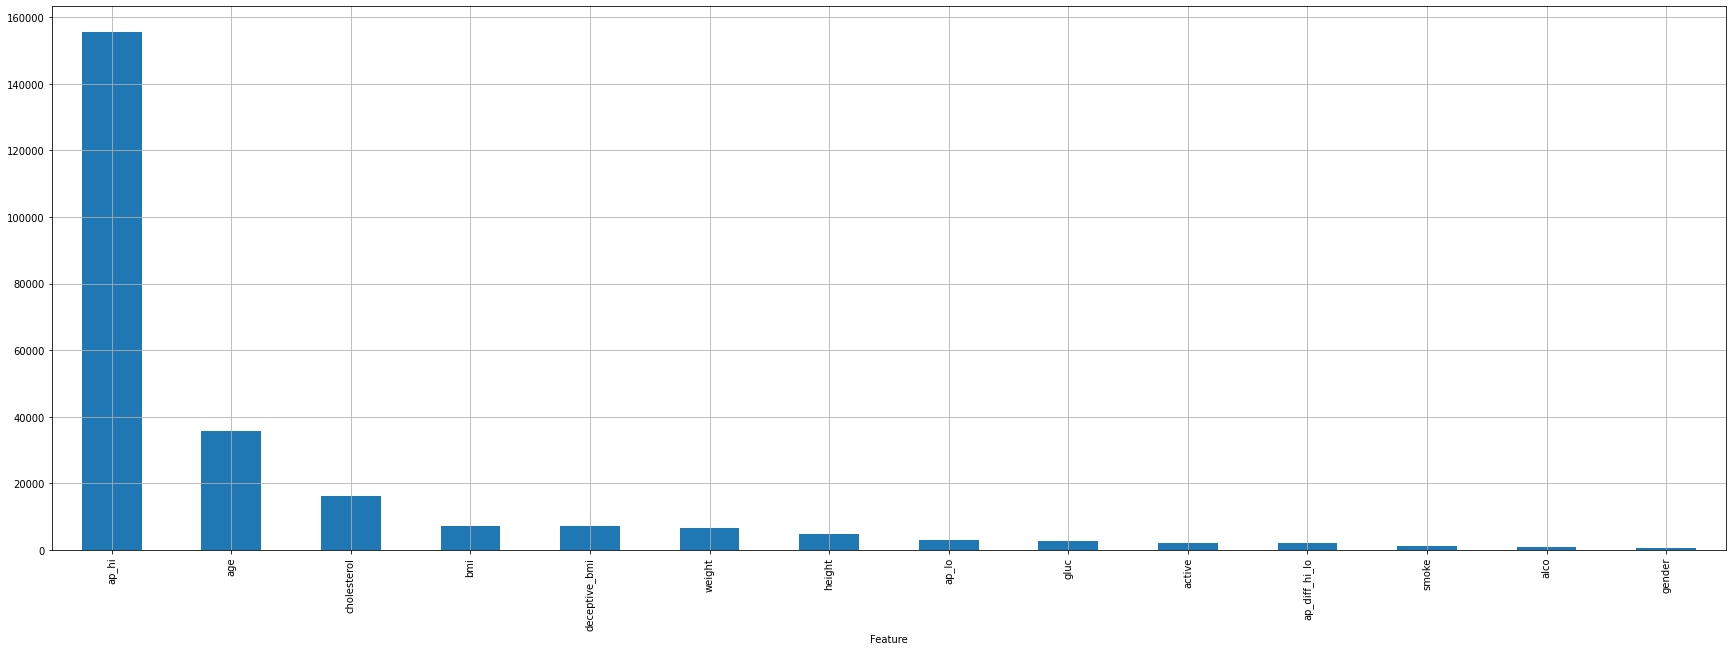

In [80]:
%%time

# Fast feature importances calculation
fast_fi = utilized_automl.get_feature_scores('fast')
fast_fi.head(30).set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

Metric calculation

In [81]:
print(f'OOF score: {roc_auc_score(train_data[TARGET_NAME].values, oof_pred.data[:, 0])}')

OOF score: 0.8046504187751992


## Предсказания на тестовом датасете

In [82]:
test_pred = automl.predict(test_data)
print(f'Prediction for te_data:\n{test_pred}\nShape = {test_pred.shape}')

Prediction for te_data:
array([[0.4913465 ],
       [0.5509892 ],
       [0.40446842],
       ...,
       [0.4552232 ],
       [0.31811383],
       [0.6944631 ]], dtype=float32)
Shape = (30000, 1)


In [83]:
utilized_test_pred = utilized_automl.predict(test_data)
print(f'Utilized prediction for te_data:\n{utilized_test_pred}\nShape = {utilized_test_pred.shape}')

Utilized prediction for te_data:
array([[0.4950991 ],
       [0.5548192 ],
       [0.39348635],
       ...,
       [0.43952885],
       [0.32406482],
       [0.66934556]], dtype=float32)
Shape = (30000, 1)


In [84]:
submission[TARGET_NAME] = test_pred.data[:, 0]
submission.to_csv('lightautoml_tabularautoml.csv', index = False)
submission[TARGET_NAME] = utilized_test_pred.data[:, 0]
submission.to_csv('lightautoml_tabularutilizedautoml.csv', index = False)
submission[TARGET_NAME] = 0.5 * test_pred.data[:, 0] + 0.5 * utilized_test_pred.data[:, 0]
submission.to_csv('lightautoml_combo.csv', index = False)